In [51]:
    import hopsworks
    import pandas as pd
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn.metrics import ConfusionMatrixDisplay
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib
    import os
    from dotenv import load_dotenv, dotenv_values


In [52]:
    # REPLACE .env WITH YOUR OWN KEY_VALUE
    config = dotenv_values(".env")
    key_value = config["KEY"]
    #print(key_value)

In [53]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login(api_key_value=key_value)
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/193692
Connected. Call `.close()` to terminate connection gracefully.


In [54]:
#CONSTRUCTS 'FEATURE VIEW' from 'FEATURE GROUP' that is already saved from before on hopsworks, LABELS coming into play now, remember feature group only had features
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from Wine quality dataset",
                                  labels=["quality"],
                                  query=query)

In [55]:
'''
read_wine_csv = pd.read_csv("wine_final.csv")
read_wine_csv
y = read_wine_csv['quality']
print(y)
'''

0       6
1       6
2       6
3       6
4       6
       ..
6492    5
6493    6
6494    6
6495    5
6496    6
Name: quality, Length: 6497, dtype: int64


In [54]:
#feature_view.get_batch_data()


Finished: Reading data from Hopsworks, using Hive (3.89s) 


,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
0,1,6.9,0.290,0.320000,5.8,0.040,16.0,112.0,0.99300,3.040000,0.580000,11.2
1,1,7.4,0.280,0.250000,11.9,0.053,25.0,148.0,0.99760,3.100000,0.620000,9.2
2,1,7.5,0.240,0.310000,13.1,0.050,26.0,180.0,0.99884,3.050000,0.530000,9.1
3,1,6.7,0.220,0.330000,1.2,0.036,36.0,86.0,0.99058,3.100000,0.760000,11.4
4,1,8.3,0.140,0.450000,1.5,0.039,18.0,98.0,0.99215,3.020000,0.560000,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5361,1,6.7,0.220,0.370000,1.6,0.028,24.0,102.0,0.99130,3.114707,0.590000,11.6
5362,0,7.0,0.540,0.094268,2.1,0.079,39.0,55.0,0.99560,3.390000,0.840000,11.4
5363,1,7.5,0.240,0.270998,13.0,0.049,46.0,217.0,0.99850,3.080000,0.530000,8.8
5364,1,6.8,0.220,0.350000,17.5,0.039,38.0,153.0,0.99940,3.188502,0.420000,9.0


In [33]:
#trying xgboost
'''
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

label_encoder = LabelEncoder()

X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size=0.3) #stratify=y)           #80:20 split

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(xgb.XGBClassifier(objective="multi:softmax", random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train_encoded)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
'''

Finished: Reading data from Hopsworks, using ArrowFlight (1.20s) 


'\nmodel = xgb.XGBClassifier(objective="multi:softmax", random_state=42)\nmodel.fit(X_train, y_train_encoded)\ny_pred_encoded = model.predict(X_test)\n\ny_pred = label_encoder.inverse_transform(y_pred_encoded)\n\naccuracy = accuracy_score(y_test, y_pred)\nprint(f"Accuracy: {accuracy}")\n\nconf_matrix = confusion_matrix(y_test, y_pred)\nprint("Confusion Matrix:")\nprint(conf_matrix)\n'

In [44]:
# Build best params model for xgboost
'''
print(best_params)

final_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=7,
    max_depth=best_params['max_depth'], #7
    learning_rate=best_params['learning_rate'], #0.2
    n_estimators=best_params['n_estimators'], #100
    random_state=42
)

final_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=7,
    max_depth=7, #7
    learning_rate=best_params['learning_rate'], #0.2
    n_estimators=best_params['n_estimators'], #100
    random_state=42
)

final_model.fit(X_train, y_train_encoded)
y_pred_encoded = final_model.predict(X_test)

y_pred = label_encoder.inverse_transform(y_pred_encoded)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
'''

{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}
Accuracy: 0.5502776064157927


In [47]:
# Trying to find RandomForestClassifier best params
'''
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train, y_train.values.ravel())

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train.values.ravel())
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy}")
print(best_params)
'''
#Final Model Accuracy: 0.567550894509562
#{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

Final Model Accuracy: 0.567550894509562
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [56]:


# You can read training data, randomly split into train/test sets of features (X) and labels (y)  #train s
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size=0.3) #stratify=y)           #80:20 split


Finished: Reading data from Hopsworks, using ArrowFlight (2.80s) 


In [57]:

# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
#model = KNeighborsClassifier(n_neighbors=2)     #CHANGE AS NEEDED
#odel = DecisionTreeClassifier()
model = RandomForestClassifier() #(random_state=42)
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier()

In [60]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

# PRINTS TO CHECK
print(model.classes_)
print("-------------------------------------------------------------------------")
print(results)
print("-------------------------------------------------------------------------")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100} %\n')
print("-------------------------------------------------------------------------")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("-------------------------------------------------------------------------")
print(model.feature_names_in_)

print("-------------------------------------------------------------------------")
unique_train_y = y_train['quality'].unique()
print("Unique Classes in y_train:", unique_train_y)

unique_test_y = y_test['quality'].unique()
print("Unique Classes in y_test:", unique_test_y)

[3 4 5 6 7 8 9]
-------------------------------------------------------------------------
[[  0   0   8   4   1   0   0]
 [  0   7  34  20   1   0   0]
 [  0   3 342 190   3   0   0]
 [  0   2 146 479  58   0   0]
 [  0   0  12 166  90   0   0]
 [  0   0   1  31  15   5   0]
 [  0   0   0   2   1   0   0]]
-------------------------------------------------------------------------
Accuracy: 56.940160394818015 %

-------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00        13
           4       0.58      0.11      0.19        62
           5       0.63      0.64      0.63       538
           6       0.54      0.70      0.61       685
           7       0.53      0.34      0.41       268
           8       1.00      0.10      0.18        52
           9       0.00      0.00      0.00         3

    accuracy                           0.57      1621
 

[3, 4, 5, 6, 7, 8, 9]
<class 'list'>


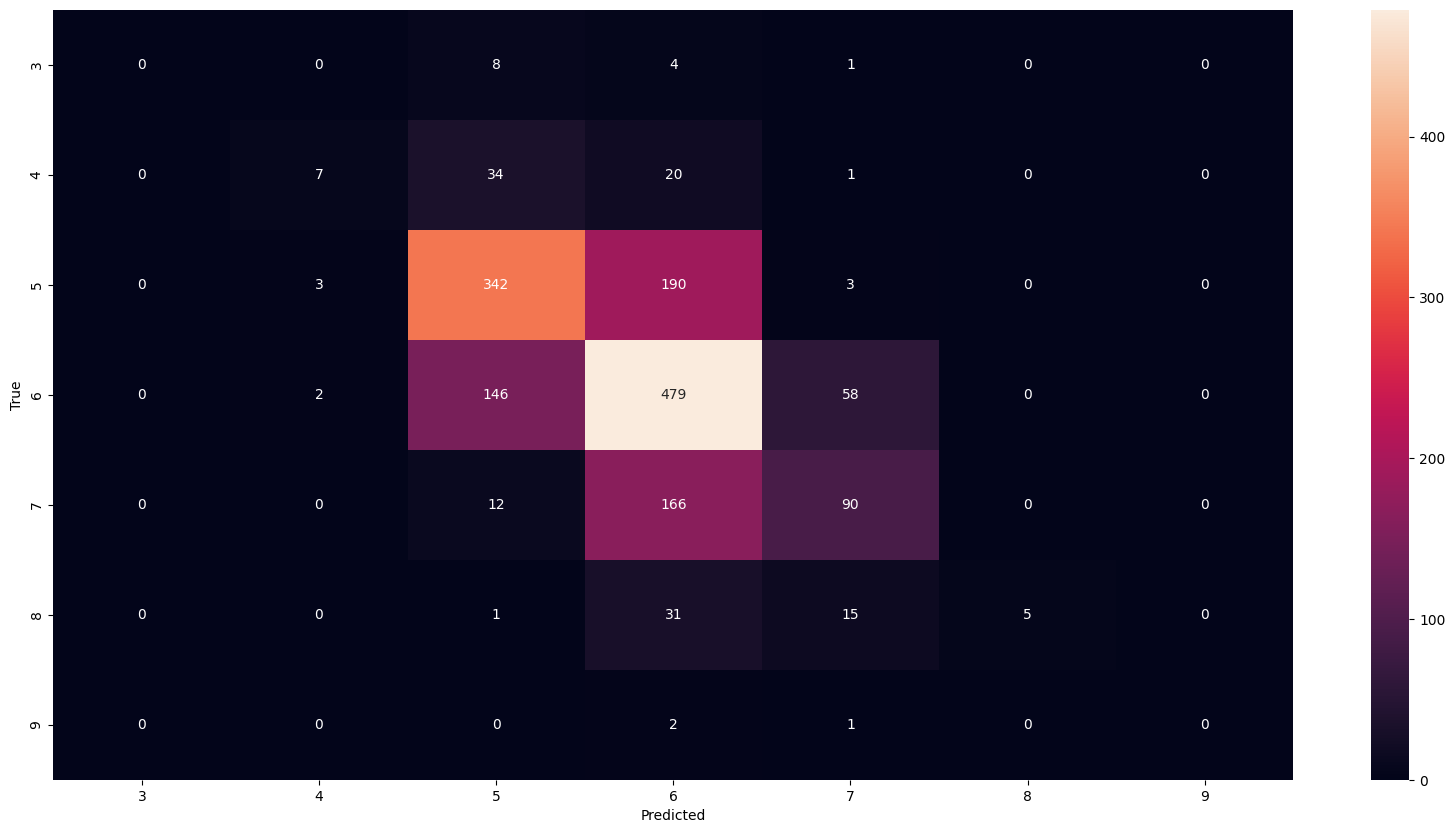

In [63]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file

# Get output classes from model
classes_list = model.classes_.tolist()
print(classes_list)
print(type(classes_list))

df_cm = pd.DataFrame(results, classes_list, classes_list)

# Create the heatmap
pyplot.figure(figsize=(20, 10))
cm = sns.heatmap(df_cm, annot=True, fmt="d")
cm.set_xlabel('Predicted')
cm.set_ylabel('True')
fig = cm.get_figure()


In [90]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'wine_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")       #binary serialization of model in python
fig.savefig(model_dir + "/wine_confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 24764609/24764609 elapsed<00:23 remaining<00:0097it/s]
Uploading: 100.000%|██████████| 30465/30465 elapsed<00:01 remaining<00:001,  2.97it/s]
Uploading: 100.000%|██████████| 1066/1066 elapsed<00:01 remaining<00:001:00, 15.17s/it]
Model export complete: 100%|██████████| 6/6 [00:33<00:00,  5.53s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/193692/models/wine_model/1


Model(name: 'wine_model', version: 1)